# ENV

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader

from einops import reduce, repeat, rearrange, einsum

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Data

In [ ]:
from torchvision import transforms
from torchvision.datasets import MNIST


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = MNIST('.', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14680631.98it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494645.41it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3472556.48it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9306560.22it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



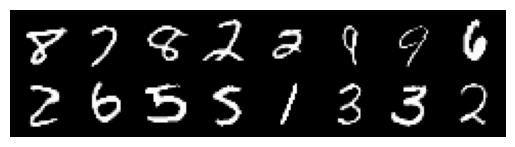

In [ ]:
from torchvision.utils import make_grid

def show_image(images, num_images, size=(1,28,28)):
    image_grid = make_grid(images[:num_images].detach().cpu(), nrow=8)
    plt.imshow(rearrange(image_grid, 'a b c -> b c a').squeeze())
    plt.axis('off')
    plt.show()

show_image(next(iter(dataloader))[0], 16)

# Architecture

In [ ]:
from einops.layers.torch import Rearrange

class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2):
        super().__init__()
        self.layer = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layer(x)

class Generator(nn.Module):
    def __init__(self, z_dim, image_channel, hidden_dim):
        super().__init__()
        self.gen = nn.Sequential(Rearrange('b c -> b c 1 1'),
                                 GenBlock(z_dim, hidden_dim*4),
                                 GenBlock(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
                                 GenBlock(hidden_dim*2, hidden_dim),
                                 nn.ConvTranspose2d(hidden_dim, image_channel, kernel_size=4, stride=2),
                                 nn.Tanh())
    def forward(self, x):
        return self.gen(x)

x = torch.rand(1,10)
tmp=Generator(10, 1, 64)
tmp(x).shape

torch.Size([1, 1, 28, 28])

In [ ]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2):
        super().__init__()
        self.layer = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride)),
                                   nn.BatchNorm2d(out_channels),
                                   nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, x):
        return self.layer(x)

class Discriminator(nn.Module):
    def __init__(self, image_channel, hidden_dim):
        super().__init__()
        self.disc = nn.Sequential(DiscBlock(image_channel, hidden_dim),
                                  DiscBlock(hidden_dim, hidden_dim*2),
                                  nn.utils.spectral_norm((nn.Conv2d(hidden_dim*2, 1, kernel_size=4, stride=2))))

    def forward(self, x):
        x = self.disc(x)
        return rearrange(x, 'b c h w -> b (c h w)')

x = torch.rand(7, 1, 28, 28)
tmp=Discriminator(1,16)
tmp(x).shape

torch.Size([7, 1])

# Training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
z_dim=64
batch_size = 4096*4
learning_rate= 1e-2

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
criterion=nn.BCEWithLogitsLoss()

gen = Generator(z_dim, 1, 64).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))

disc = Discriminator(1, 16).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

def weight_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        torch.nn.init.kaiming_normal_(layer.weight)
    if isinstance(layer, nn.BatchNorm2d):
        torch.nn.init.normal_(layer.weight, 0.0, 0.02)
        torch.nn.init.constant_(layer.bias, 0)

gen=gen.apply(weight_init)
disc= disc.apply(weight_init)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/3 [00:00<?, ?it/s]

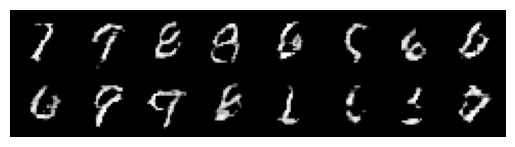

Epoch 2/200:   0%|          | 0/3 [00:00<?, ?it/s]

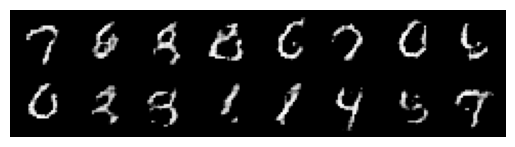

Epoch 3/200:   0%|          | 0/3 [00:00<?, ?it/s]

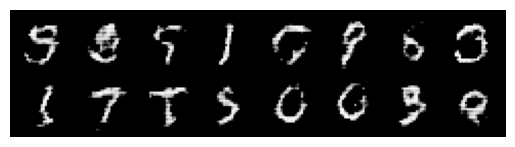

Epoch 4/200:   0%|          | 0/3 [00:00<?, ?it/s]

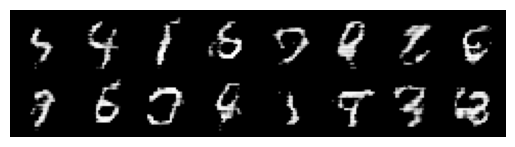

Epoch 5/200:   0%|          | 0/3 [00:00<?, ?it/s]

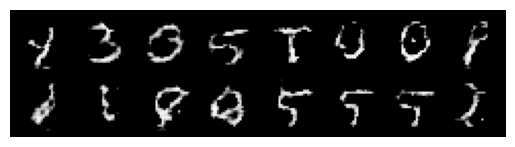

Epoch 6/200:   0%|          | 0/3 [00:00<?, ?it/s]

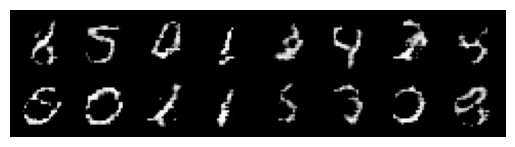

Epoch 7/200:   0%|          | 0/3 [00:00<?, ?it/s]

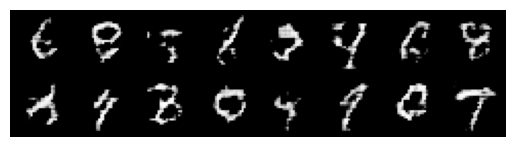

Epoch 8/200:   0%|          | 0/3 [00:00<?, ?it/s]

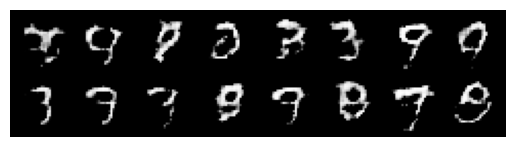

Epoch 9/200:   0%|          | 0/3 [00:00<?, ?it/s]

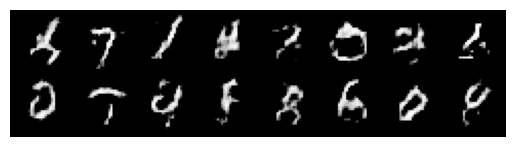

Epoch 10/200:   0%|          | 0/3 [00:00<?, ?it/s]

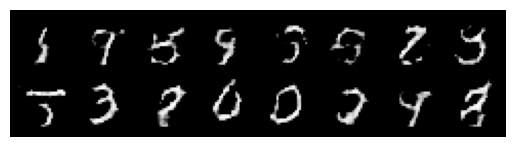

Epoch 11/200:   0%|          | 0/3 [00:00<?, ?it/s]

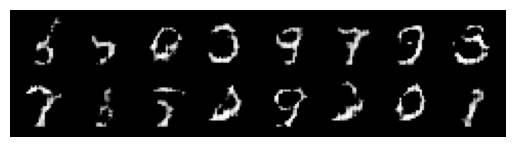

Epoch 12/200:   0%|          | 0/3 [00:00<?, ?it/s]

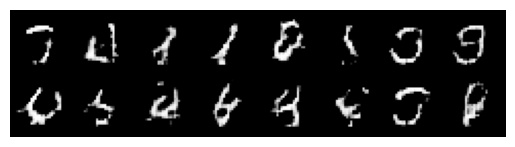

Epoch 13/200:   0%|          | 0/3 [00:00<?, ?it/s]

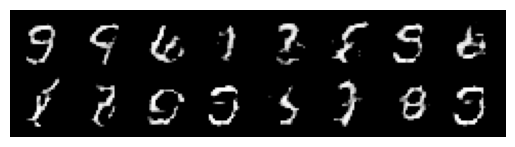

Epoch 14/200:   0%|          | 0/3 [00:00<?, ?it/s]

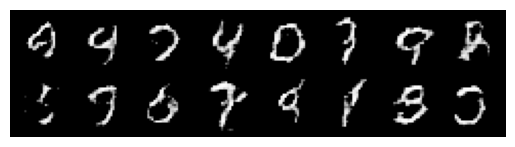

Epoch 15/200:   0%|          | 0/3 [00:00<?, ?it/s]

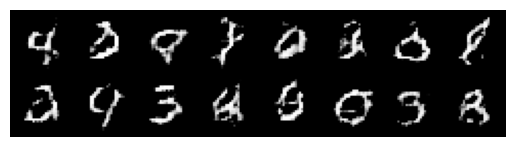

Epoch 16/200:   0%|          | 0/3 [00:00<?, ?it/s]

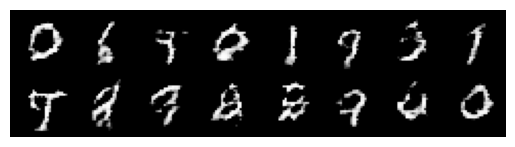

Epoch 17/200:   0%|          | 0/3 [00:00<?, ?it/s]

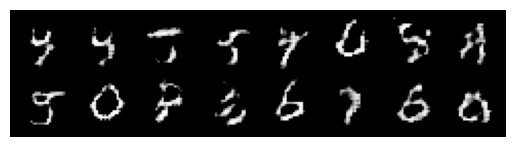

Epoch 18/200:   0%|          | 0/3 [00:00<?, ?it/s]

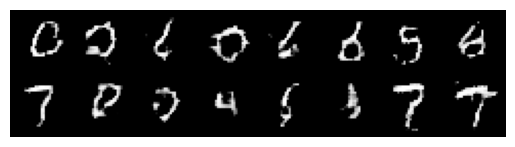

Epoch 19/200:   0%|          | 0/3 [00:00<?, ?it/s]

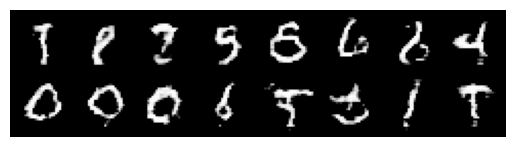

Epoch 20/200:   0%|          | 0/3 [00:00<?, ?it/s]

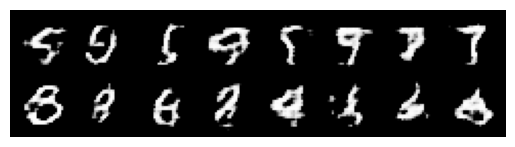

Epoch 21/200:   0%|          | 0/3 [00:00<?, ?it/s]

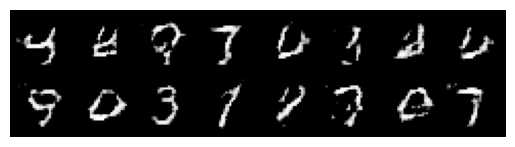

Epoch 22/200:   0%|          | 0/3 [00:00<?, ?it/s]

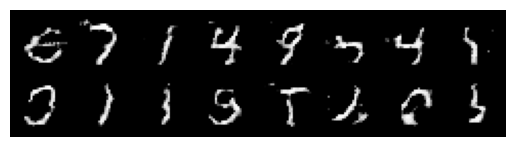

Epoch 23/200:   0%|          | 0/3 [00:00<?, ?it/s]

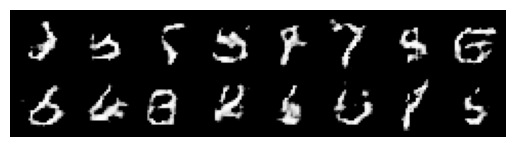

Epoch 24/200:   0%|          | 0/3 [00:00<?, ?it/s]

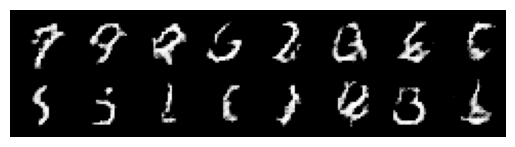

Epoch 25/200:   0%|          | 0/3 [00:00<?, ?it/s]

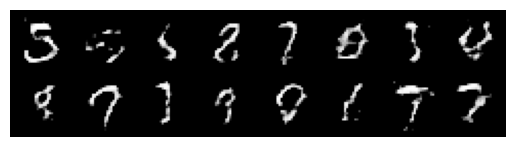

Epoch 26/200:   0%|          | 0/3 [00:00<?, ?it/s]

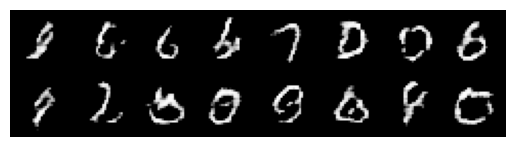

Epoch 27/200:   0%|          | 0/3 [00:00<?, ?it/s]

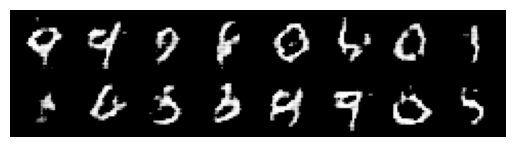

Epoch 28/200:   0%|          | 0/3 [00:00<?, ?it/s]

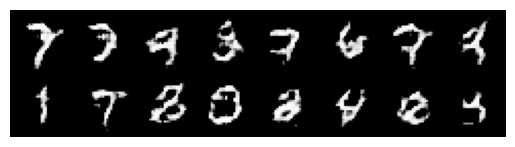

Epoch 29/200:   0%|          | 0/3 [00:00<?, ?it/s]

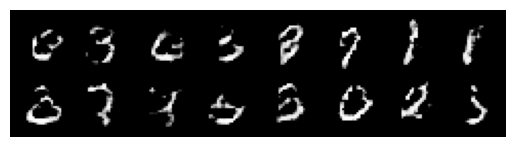

Epoch 30/200:   0%|          | 0/3 [00:00<?, ?it/s]

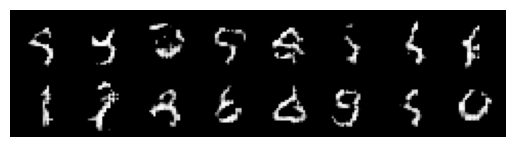

Epoch 31/200:   0%|          | 0/3 [00:00<?, ?it/s]

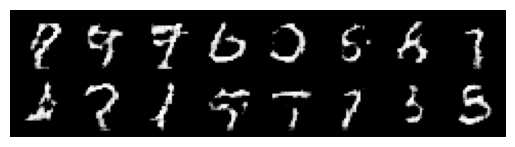

Epoch 32/200:   0%|          | 0/3 [00:00<?, ?it/s]

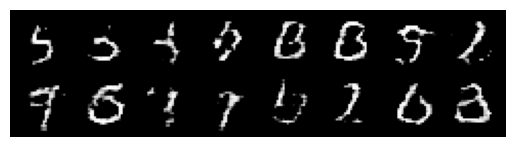

Epoch 33/200:   0%|          | 0/3 [00:00<?, ?it/s]

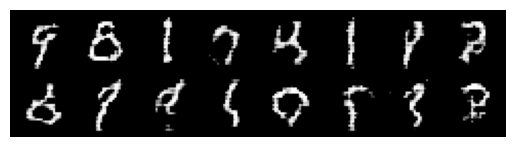

Epoch 34/200:   0%|          | 0/3 [00:00<?, ?it/s]

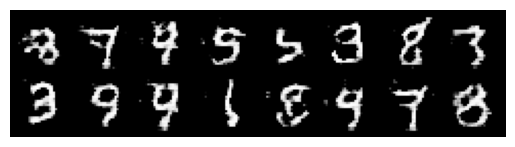

Epoch 35/200:   0%|          | 0/3 [00:00<?, ?it/s]

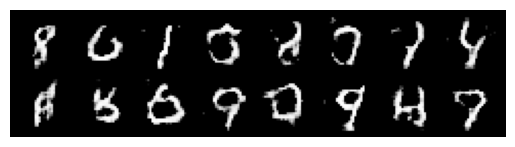

Epoch 36/200:   0%|          | 0/3 [00:00<?, ?it/s]

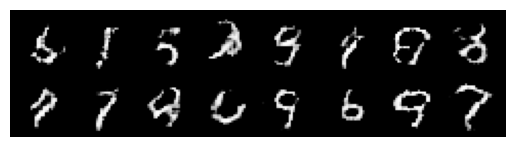

Epoch 37/200:   0%|          | 0/3 [00:00<?, ?it/s]

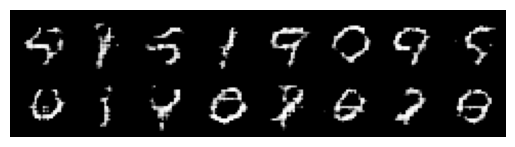

Epoch 38/200:   0%|          | 0/3 [00:00<?, ?it/s]

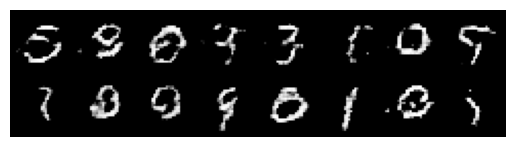

Epoch 39/200:   0%|          | 0/3 [00:00<?, ?it/s]

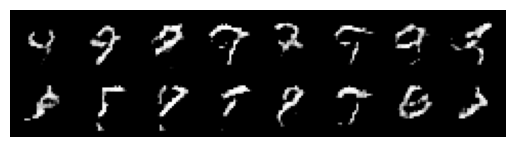

Epoch 40/200:   0%|          | 0/3 [00:00<?, ?it/s]

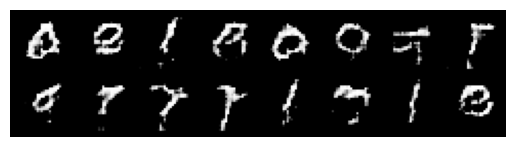

Epoch 41/200:   0%|          | 0/3 [00:00<?, ?it/s]

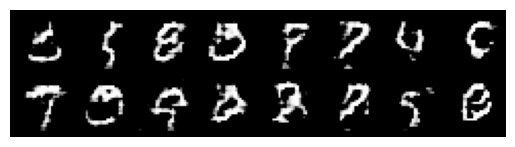

Epoch 42/200:   0%|          | 0/3 [00:00<?, ?it/s]

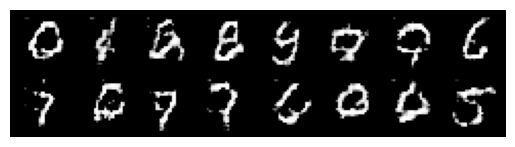

Epoch 43/200:   0%|          | 0/3 [00:00<?, ?it/s]

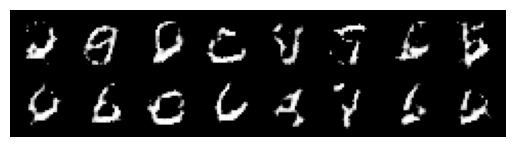

Epoch 44/200:   0%|          | 0/3 [00:00<?, ?it/s]

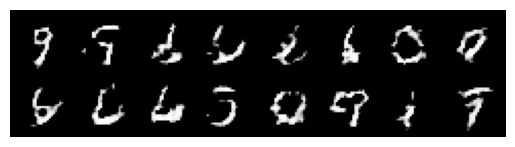

Epoch 45/200:   0%|          | 0/3 [00:00<?, ?it/s]

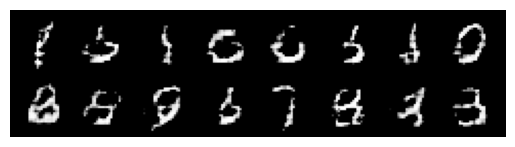

Epoch 46/200:   0%|          | 0/3 [00:00<?, ?it/s]

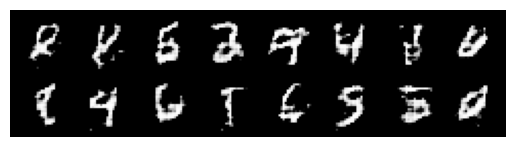

Epoch 47/200:   0%|          | 0/3 [00:00<?, ?it/s]

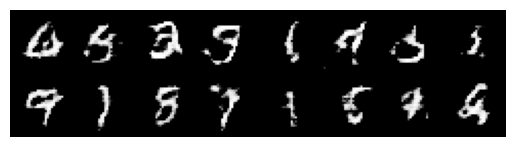

Epoch 48/200:   0%|          | 0/3 [00:00<?, ?it/s]

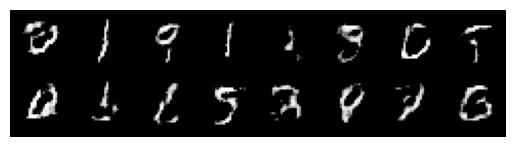

Epoch 49/200:   0%|          | 0/3 [00:00<?, ?it/s]

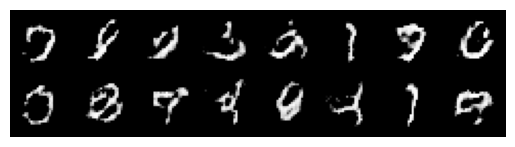

Epoch 50/200:   0%|          | 0/3 [00:00<?, ?it/s]

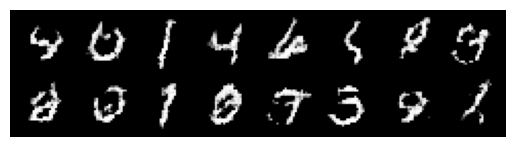

Epoch 51/200:   0%|          | 0/3 [00:00<?, ?it/s]

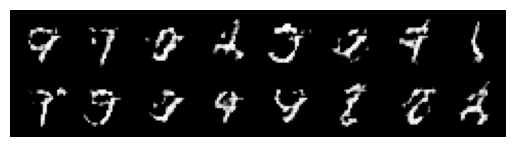

Epoch 52/200:   0%|          | 0/3 [00:00<?, ?it/s]

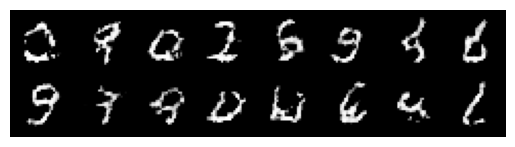

Epoch 53/200:   0%|          | 0/3 [00:00<?, ?it/s]

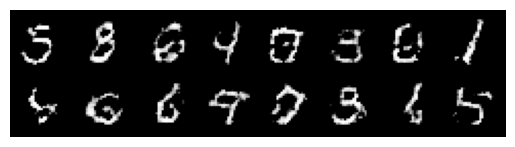

Epoch 54/200:   0%|          | 0/3 [00:00<?, ?it/s]

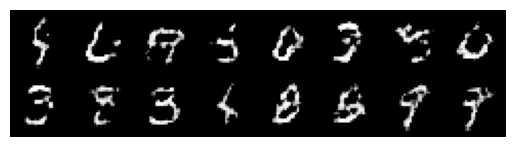

Epoch 55/200:   0%|          | 0/3 [00:00<?, ?it/s]

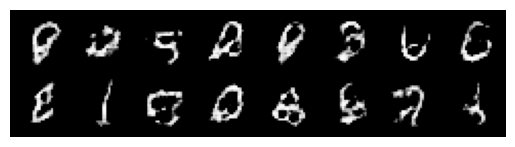

Epoch 56/200:   0%|          | 0/3 [00:00<?, ?it/s]

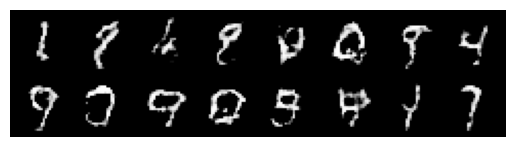

Epoch 57/200:   0%|          | 0/3 [00:00<?, ?it/s]

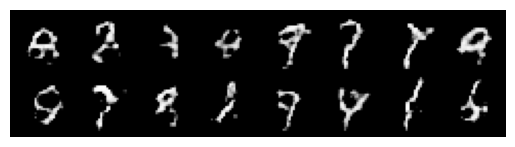

Epoch 58/200:   0%|          | 0/3 [00:00<?, ?it/s]

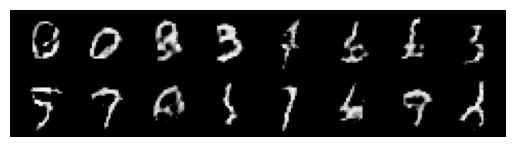

Epoch 59/200:   0%|          | 0/3 [00:00<?, ?it/s]

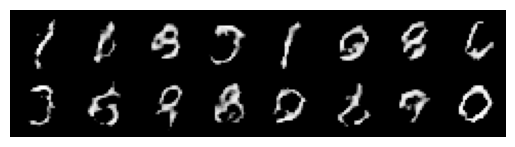

Epoch 60/200:   0%|          | 0/3 [00:00<?, ?it/s]

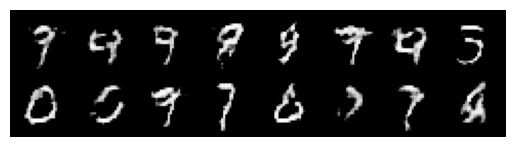

Epoch 61/200:   0%|          | 0/3 [00:00<?, ?it/s]

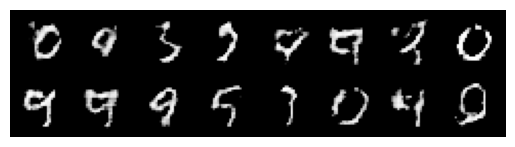

Epoch 62/200:   0%|          | 0/3 [00:00<?, ?it/s]

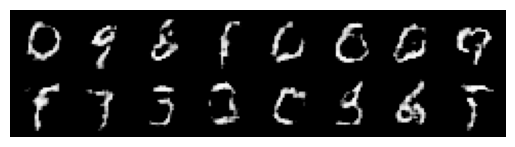

Epoch 63/200:   0%|          | 0/3 [00:00<?, ?it/s]

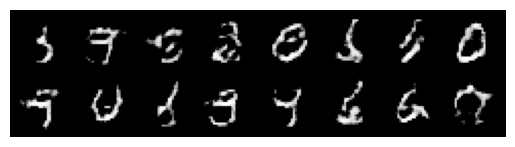

Epoch 64/200:   0%|          | 0/3 [00:00<?, ?it/s]

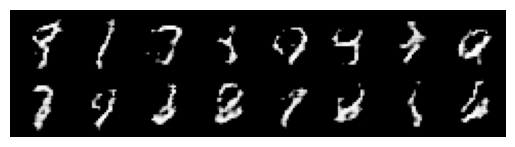

Epoch 65/200:   0%|          | 0/3 [00:00<?, ?it/s]

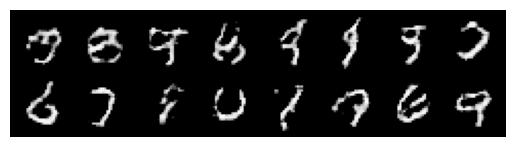

Epoch 66/200:   0%|          | 0/3 [00:00<?, ?it/s]

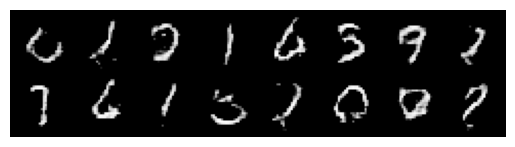

Epoch 67/200:   0%|          | 0/3 [00:00<?, ?it/s]

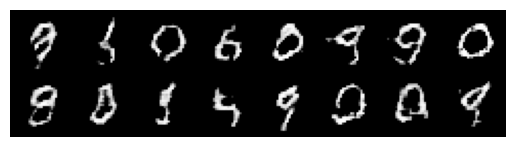

Epoch 68/200:   0%|          | 0/3 [00:00<?, ?it/s]

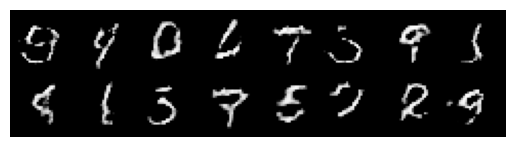

Epoch 69/200:   0%|          | 0/3 [00:00<?, ?it/s]

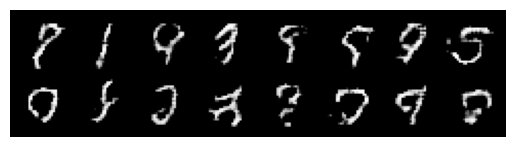

Epoch 70/200:   0%|          | 0/3 [00:00<?, ?it/s]

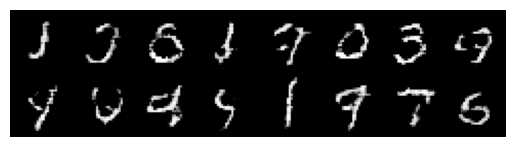

Epoch 71/200:   0%|          | 0/3 [00:00<?, ?it/s]

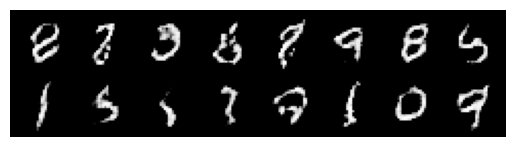

Epoch 72/200:   0%|          | 0/3 [00:00<?, ?it/s]

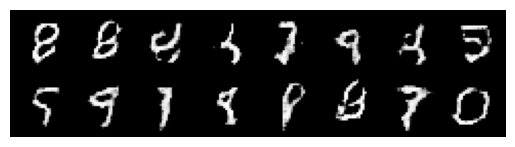

Epoch 73/200:   0%|          | 0/3 [00:00<?, ?it/s]

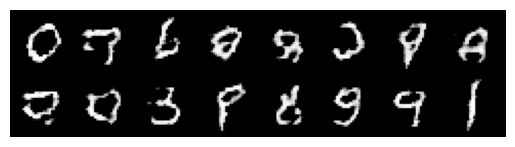

Epoch 74/200:   0%|          | 0/3 [00:00<?, ?it/s]

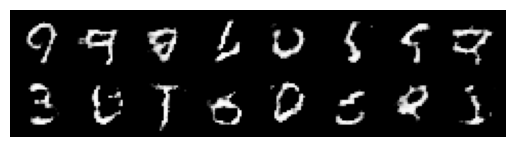

Epoch 75/200:   0%|          | 0/3 [00:00<?, ?it/s]

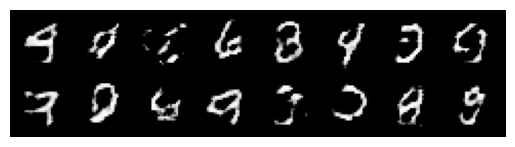

Epoch 76/200:   0%|          | 0/3 [00:00<?, ?it/s]

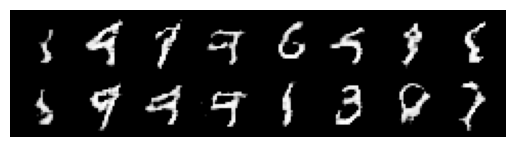

Epoch 77/200:   0%|          | 0/3 [00:00<?, ?it/s]

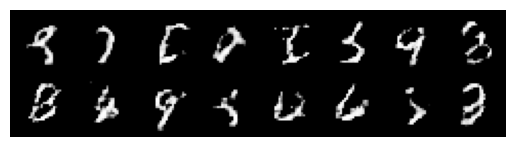

Epoch 78/200:   0%|          | 0/3 [00:00<?, ?it/s]

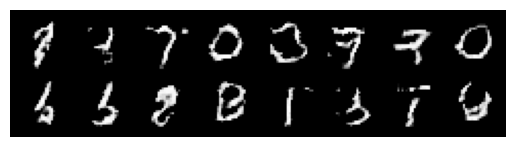

Epoch 79/200:   0%|          | 0/3 [00:00<?, ?it/s]

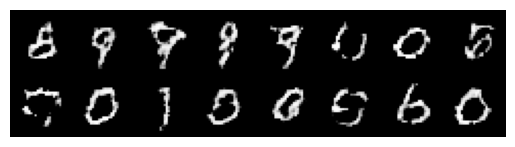

Epoch 80/200:   0%|          | 0/3 [00:00<?, ?it/s]

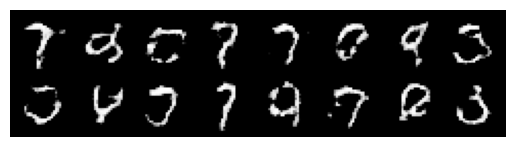

Epoch 81/200:   0%|          | 0/3 [00:00<?, ?it/s]

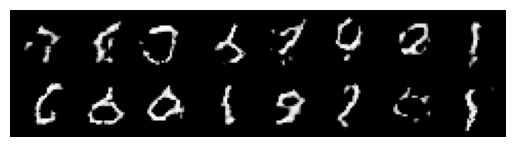

Epoch 82/200:   0%|          | 0/3 [00:00<?, ?it/s]

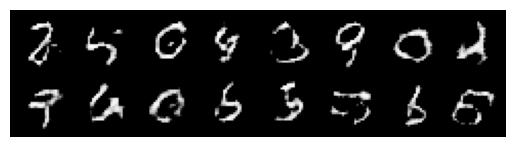

Epoch 83/200:   0%|          | 0/3 [00:00<?, ?it/s]

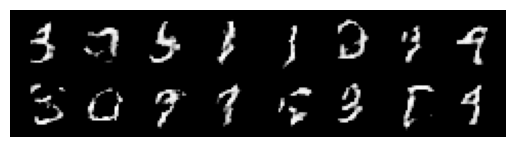

Epoch 84/200:   0%|          | 0/3 [00:00<?, ?it/s]

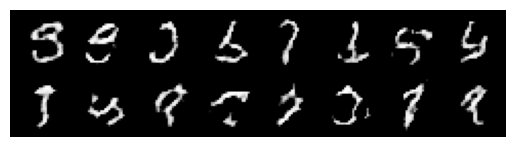

Epoch 85/200:   0%|          | 0/3 [00:00<?, ?it/s]

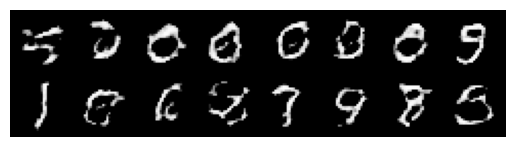

Epoch 86/200:   0%|          | 0/3 [00:00<?, ?it/s]

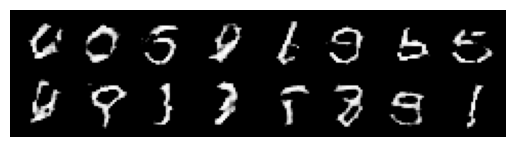

Epoch 87/200:   0%|          | 0/3 [00:00<?, ?it/s]

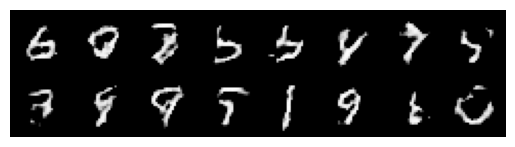

Epoch 88/200:   0%|          | 0/3 [00:00<?, ?it/s]

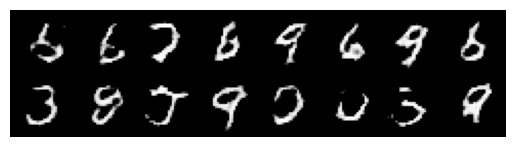

Epoch 89/200:   0%|          | 0/3 [00:00<?, ?it/s]

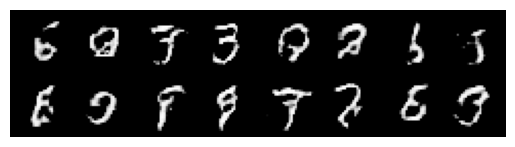

Epoch 90/200:   0%|          | 0/3 [00:00<?, ?it/s]

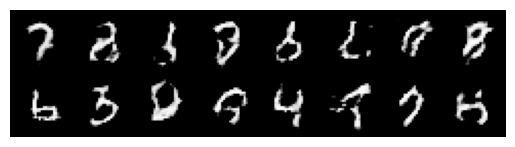

Epoch 91/200:   0%|          | 0/3 [00:00<?, ?it/s]

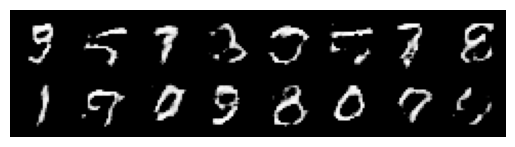

Epoch 92/200:   0%|          | 0/3 [00:00<?, ?it/s]

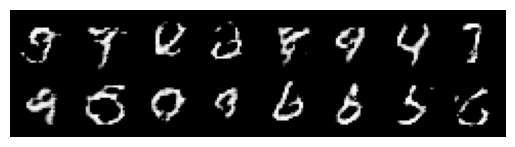

Epoch 93/200:   0%|          | 0/3 [00:00<?, ?it/s]

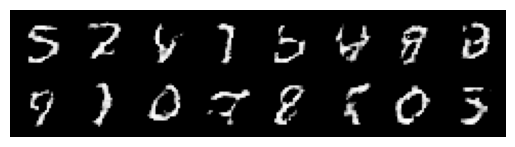

Epoch 94/200:   0%|          | 0/3 [00:00<?, ?it/s]

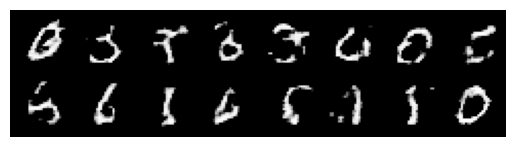

Epoch 95/200:   0%|          | 0/3 [00:00<?, ?it/s]

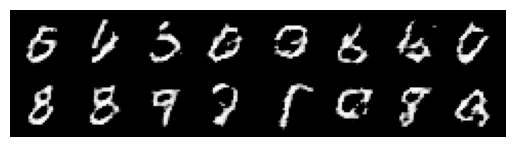

Epoch 96/200:   0%|          | 0/3 [00:00<?, ?it/s]

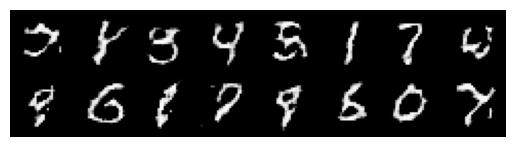

Epoch 97/200:   0%|          | 0/3 [00:00<?, ?it/s]

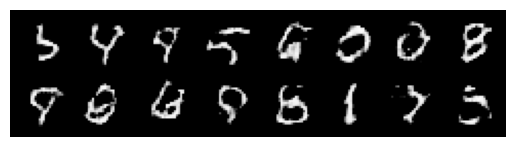

Epoch 98/200:   0%|          | 0/3 [00:00<?, ?it/s]

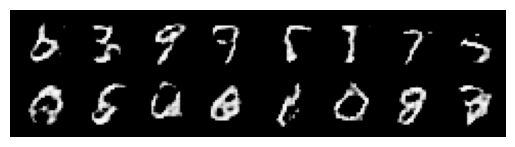

Epoch 99/200:   0%|          | 0/3 [00:00<?, ?it/s]

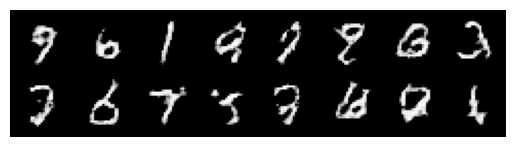

Epoch 100/200:   0%|          | 0/3 [00:00<?, ?it/s]

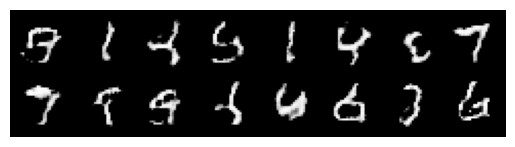

Epoch 101/200:   0%|          | 0/3 [00:00<?, ?it/s]

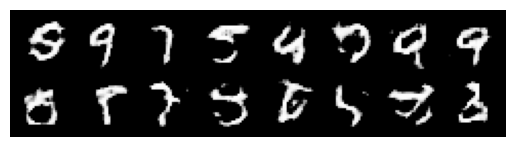

Epoch 102/200:   0%|          | 0/3 [00:00<?, ?it/s]

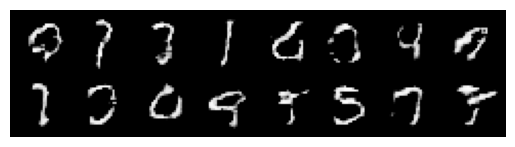

Epoch 103/200:   0%|          | 0/3 [00:00<?, ?it/s]

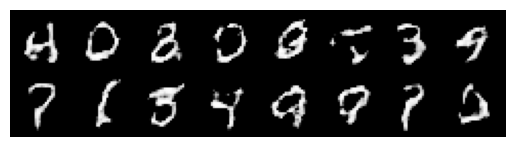

Epoch 104/200:   0%|          | 0/3 [00:00<?, ?it/s]

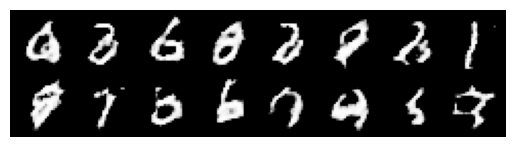

Epoch 105/200:   0%|          | 0/3 [00:00<?, ?it/s]

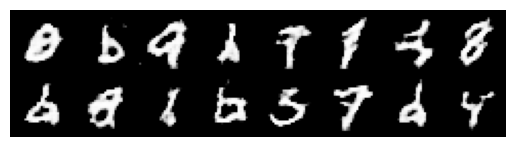

Epoch 106/200:   0%|          | 0/3 [00:00<?, ?it/s]

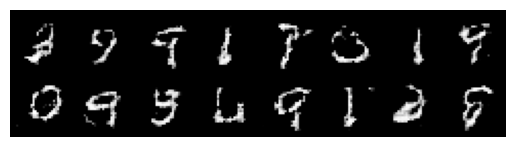

Epoch 107/200:   0%|          | 0/3 [00:00<?, ?it/s]

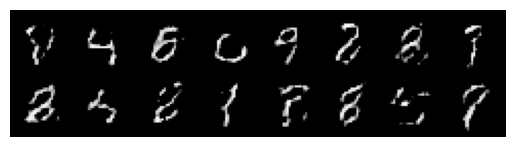

Epoch 108/200:   0%|          | 0/3 [00:00<?, ?it/s]

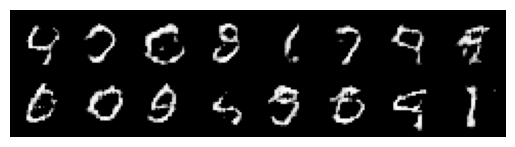

Epoch 109/200:   0%|          | 0/3 [00:00<?, ?it/s]

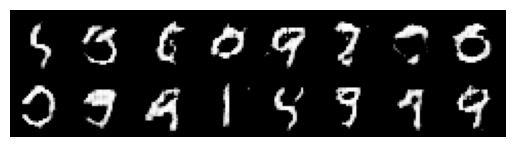

Epoch 110/200:   0%|          | 0/3 [00:00<?, ?it/s]

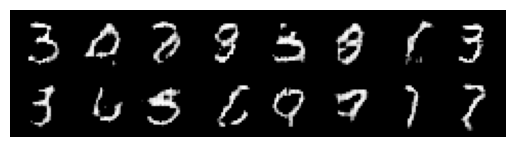

Epoch 111/200:   0%|          | 0/3 [00:00<?, ?it/s]

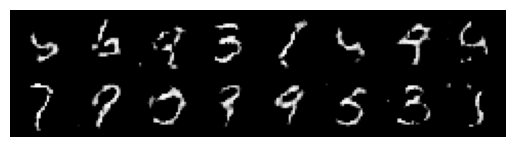

Epoch 112/200:   0%|          | 0/3 [00:00<?, ?it/s]

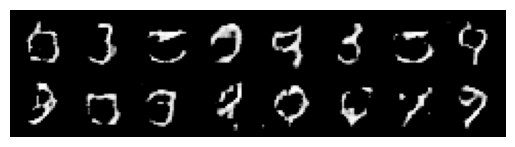

Epoch 113/200:   0%|          | 0/3 [00:00<?, ?it/s]

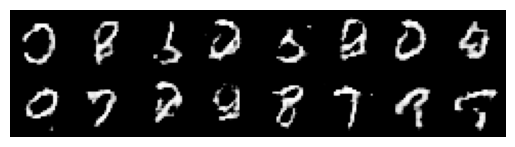

Epoch 114/200:   0%|          | 0/3 [00:00<?, ?it/s]

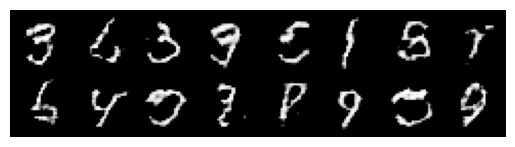

Epoch 115/200:   0%|          | 0/3 [00:00<?, ?it/s]

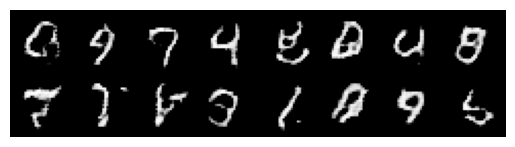

Epoch 116/200:   0%|          | 0/3 [00:00<?, ?it/s]

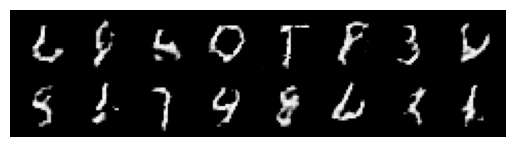

Epoch 117/200:   0%|          | 0/3 [00:00<?, ?it/s]

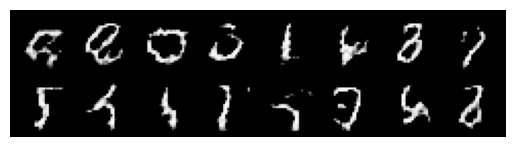

Epoch 118/200:   0%|          | 0/3 [00:00<?, ?it/s]

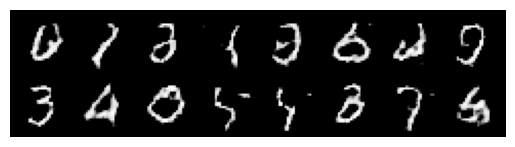

Epoch 119/200:   0%|          | 0/3 [00:00<?, ?it/s]

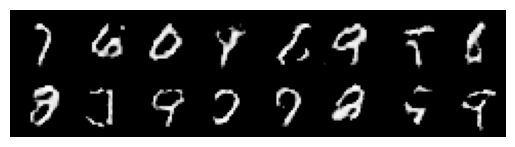

Epoch 120/200:   0%|          | 0/3 [00:00<?, ?it/s]

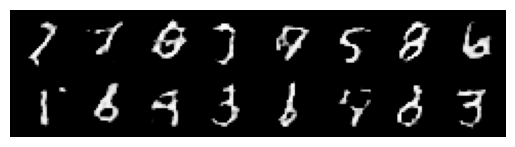

Epoch 121/200:   0%|          | 0/3 [00:00<?, ?it/s]

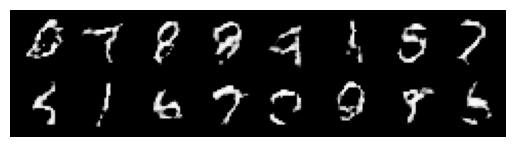

Epoch 122/200:   0%|          | 0/3 [00:00<?, ?it/s]

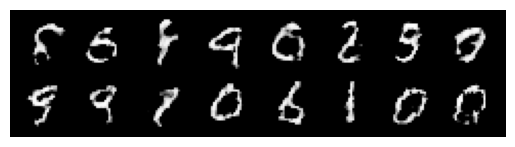

Epoch 123/200:   0%|          | 0/3 [00:00<?, ?it/s]

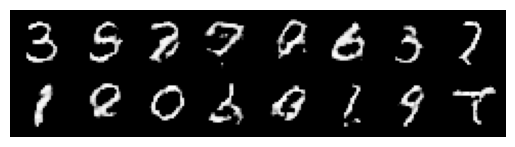

Epoch 124/200:   0%|          | 0/3 [00:00<?, ?it/s]

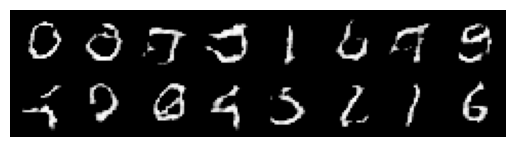

Epoch 125/200:   0%|          | 0/3 [00:00<?, ?it/s]

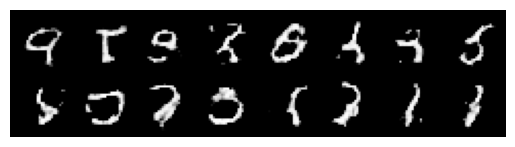

Epoch 126/200:   0%|          | 0/3 [00:00<?, ?it/s]

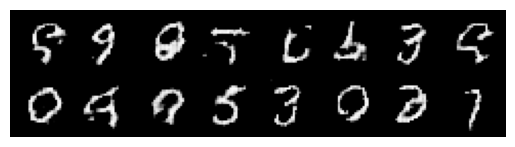

Epoch 127/200:   0%|          | 0/3 [00:00<?, ?it/s]

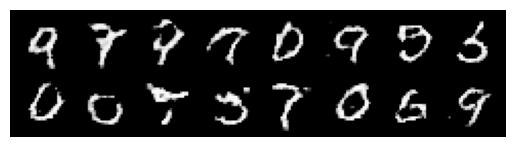

Epoch 128/200:   0%|          | 0/3 [00:00<?, ?it/s]

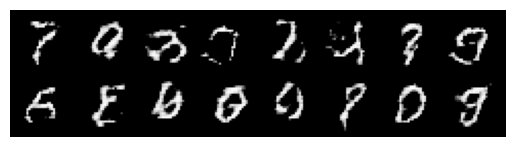

Epoch 129/200:   0%|          | 0/3 [00:00<?, ?it/s]

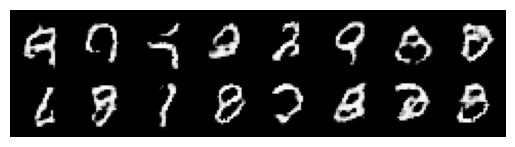

Epoch 130/200:   0%|          | 0/3 [00:00<?, ?it/s]

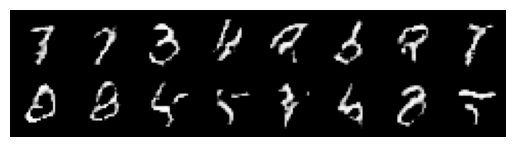

Epoch 131/200:   0%|          | 0/3 [00:00<?, ?it/s]

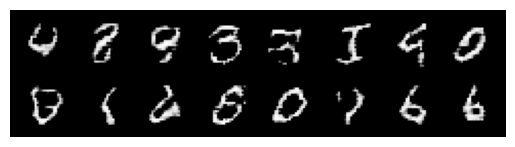

Epoch 132/200:   0%|          | 0/3 [00:00<?, ?it/s]

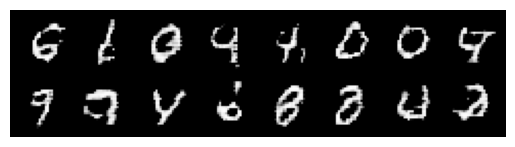

Epoch 133/200:   0%|          | 0/3 [00:00<?, ?it/s]

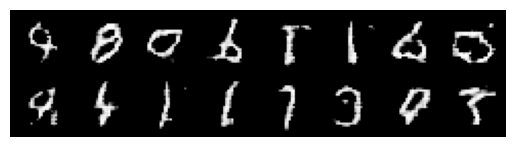

Epoch 134/200:   0%|          | 0/3 [00:00<?, ?it/s]

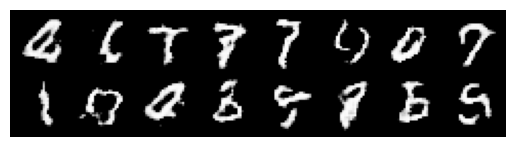

Epoch 135/200:   0%|          | 0/3 [00:00<?, ?it/s]

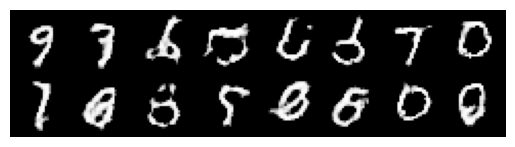

Epoch 136/200:   0%|          | 0/3 [00:00<?, ?it/s]

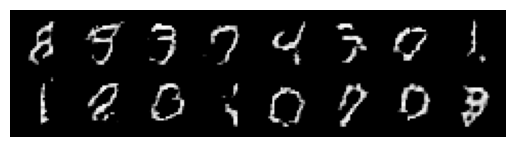

Epoch 137/200:   0%|          | 0/3 [00:00<?, ?it/s]

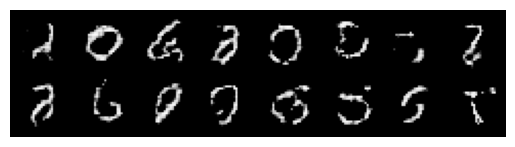

Epoch 138/200:   0%|          | 0/3 [00:00<?, ?it/s]

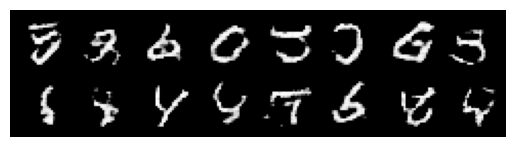

Epoch 139/200:   0%|          | 0/3 [00:00<?, ?it/s]

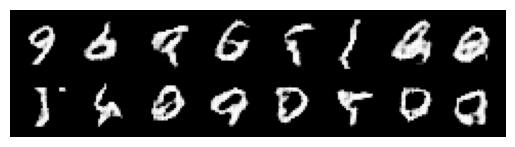

Epoch 140/200:   0%|          | 0/3 [00:00<?, ?it/s]

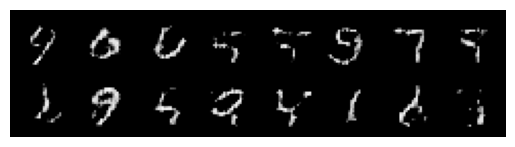

Epoch 141/200:   0%|          | 0/3 [00:00<?, ?it/s]

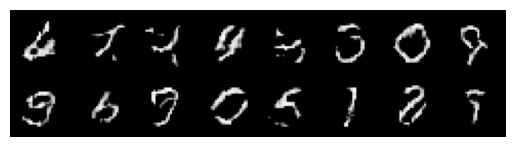

Epoch 142/200:   0%|          | 0/3 [00:00<?, ?it/s]

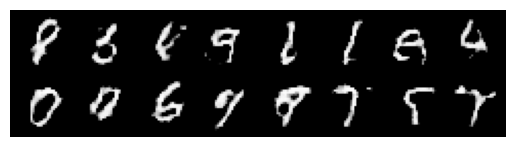

Epoch 143/200:   0%|          | 0/3 [00:00<?, ?it/s]

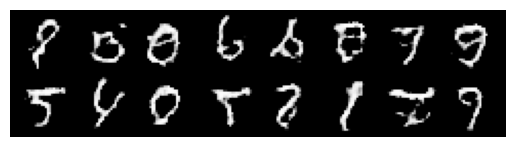

Epoch 144/200:   0%|          | 0/3 [00:00<?, ?it/s]

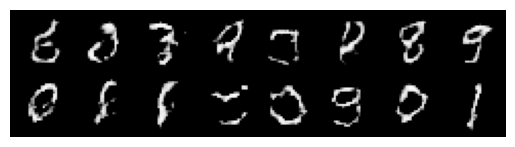

Epoch 145/200:   0%|          | 0/3 [00:00<?, ?it/s]

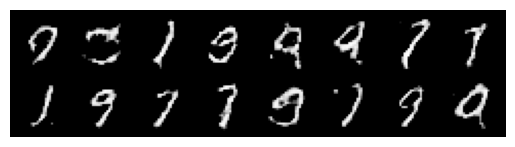

Epoch 146/200:   0%|          | 0/3 [00:00<?, ?it/s]

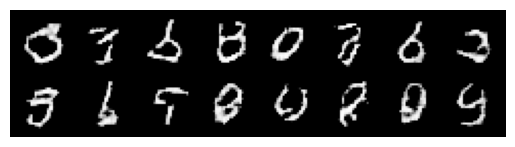

Epoch 147/200:   0%|          | 0/3 [00:00<?, ?it/s]

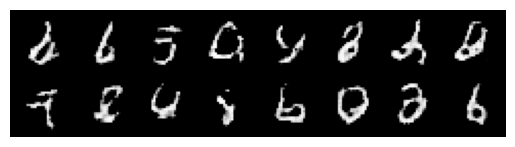

Epoch 148/200:   0%|          | 0/3 [00:00<?, ?it/s]

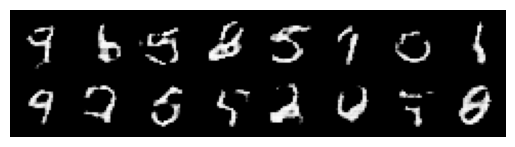

Epoch 149/200:   0%|          | 0/3 [00:00<?, ?it/s]

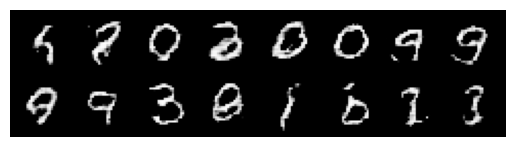

Epoch 150/200:   0%|          | 0/3 [00:00<?, ?it/s]

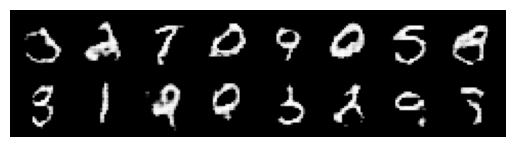

Epoch 151/200:   0%|          | 0/3 [00:00<?, ?it/s]

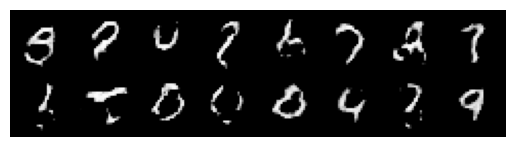

Epoch 152/200:   0%|          | 0/3 [00:00<?, ?it/s]

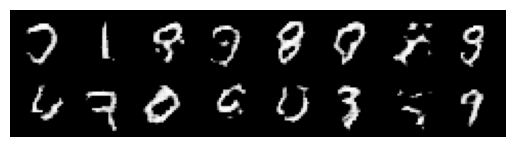

Epoch 153/200:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
num_epochs=400

for epoch in tqdm(range(num_epochs)):
    p_bar=tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}: ')
    for real,_ in p_bar:
        real=real.to(device)

        disc_opt.zero_grad()
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = gen(noise).detach()

        fake_pred = disc(fake)
        fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred, device=device))
        fake_acc = reduce((torch.signmoid(fake_pred)<0.5).float(), 'b 1 -> ()', 'mean')

        real_pred = disc(real)
        real_loss = criterion(real_pred, torch.ones_like(real_pred,device=device))
        real_acc = reduce((torch.sigmoid(real_pred)>=0.5).float(), 'b 1 -> ()', 'mean')

        disc_loss = (fake_loss+real_loss)/2
        disc_acc = (fake_acc+real_acc)/2

        disc_loss.backward()
        disc_opt.step()



        gen_opt.zero_grad()
        noise=torch.randn(batch_size, z_dim, device=device)
        fake=gen(noise)
        pred=disc(fake)
        gen_loss = criterion(pred,torch.ones_like(pred,device=device))
        gen_acc = reduce((torch.sigmoid(pred)>=0.5).float(), 'b 1 -> ()', 'mean')

        gen_loss.backward()
        gen_opt.step()

        p_bar.set_postfix(gen_loss=gen_loss.item(), disc_loss=disc_loss.item(), disc_acc=disc_acc.item(), gen_acc=gen_acc.item())

    noise = torch.randn(batch_size,z_dim,device=device)
    fake=gen(noise)
    show_image(fake, 16)